# Adding to the API Documentation

Documentation is an integral part of every collaborative software project. Good documentation not only encourages users of the package to try out different functionalities, but it also makes maintaining and expanding code significantly easier. Every code contribution to the package must come with appropriate documentation of the API. This guide details how to do this.

## Docstrings

The main form of documentation are docstrings, multi-line comments beneath a class or function definition with a specific syntax, which detail its functionality. This package uses the
[NumPy docstring format](https://numpydoc.readthedocs.io/en/latest/format.html#numpydoc-docstring-guide>). As a rule, all functions which are exposed to the user *must* have appropriate docstrings. Below is an example of a docstring for a probabilistic numerical method.

In [ ]:
# %load -s problinsolve ../../../src/probnum/linalg/linearsolvers/linearsolvers.py
def problinsolve(
    A: SquareLinOp,
    b: RandomVecMat,
    A0: Optional[SquareLinOp] = None,
    Ainv0: Optional[SquareLinOp] = None,
    x0: Optional[RandomVecMat] = None,
    assume_A: str = "sympos",
    maxiter: Optional[int] = None,
    atol: float = 10 ** -6,
    rtol: float = 10 ** -6,
    callback: Optional[Callable] = None,
    **kwargs
) -> Tuple[
    "probnum.RandomVariable", "probnum.RandomVariable", "probnum.RandomVariable", Dict
]:
    """
    Infer a solution to the linear system :math:`A x = b` in a Bayesian framework.

    Probabilistic linear solvers infer solutions to problems of the form

    .. math:: Ax=b,

    where :math:`A \\in \\mathbb{R}^{n \\times n}` and :math:`b \\in \\mathbb{R}^{n}`.
    They return a probability measure which quantifies uncertainty in the output arising
    from finite computational resources. This solver can take prior information either
    on the linear operator :math:`A` or its inverse :math:`H=A^{-1}` in the form of a
    random variable ``A0`` or ``Ainv0`` and outputs a posterior belief over :math:`A` or
    :math:`H`. This code implements the method described in Wenger et al. [1]_ based on
    the work in Hennig et al. [2]_.

    Parameters
    ----------
    A :
        *shape=(n, n)* -- A square linear operator (or matrix). Only matrix-vector
        products :math:`v \\mapsto Av` are used internally.
    b :
        *shape=(n, ) or (n, nrhs)* -- Right-hand side vector, matrix or random
        variable in :math:`A x = b`. For multiple right hand sides, ``nrhs`` problems
        are solved sequentially with the posteriors over the matrices acting as priors
        for subsequent solves. If the right-hand-side is assumed to be noisy, every
        iteration of the solver samples a realization from ``b``.
    A0 :
        *shape=(n, n)* -- A square matrix, linear operator or random variable
        representing the prior belief over the linear operator :math:`A`. If an array or
        linear operator is given, a prior distribution is chosen automatically.
    Ainv0 :
        *shape=(n, n)* -- A square matrix, linear operator or random variable
        representing the prior belief over the inverse :math:`H=A^{-1}`. This can be
        viewed as taking the form of a pre-conditioner. If an array or linear operator
        is given, a prior distribution is chosen automatically.
    x0 :
        *shape=(n, ) or (n, nrhs)* -- Prior belief for the solution of the linear
        system. Will be ignored if ``Ainv0`` is given.
    assume_A :
        Assumptions on the linear operator which can influence solver choice and
        behavior. The available options are (combinations of)

        ====================  =========
         generic matrix       ``gen``
         symmetric            ``sym``
         positive definite    ``pos``
         (additive) noise     ``noise``
        ====================  =========

    maxiter :
        Maximum number of iterations. Defaults to :math:`10n`, where :math:`n` is the
        dimension of :math:`A`.
    atol :
        Absolute convergence tolerance.
    rtol :
        Relative convergence tolerance.
    callback :
        User-supplied function called after each iteration of the linear solver. It is
        called as ``callback(xk, Ak, Ainvk, sk, yk, alphak, resid, **kwargs)`` and can
        be used to return quantities from the iteration. Note that depending on the
        function supplied, this can slow down the solver considerably.
    kwargs : optional
        Optional keyword arguments passed onto the solver iteration.

    Returns
    -------
    x :
        Approximate solution :math:`x` to the linear system. Shape of the return matches
        the shape of ``b``.
    A :
        Posterior belief over the linear operator.
    Ainv :
        Posterior belief over the linear operator inverse :math:`H=A^{-1}`.
    info :
        Information on convergence of the solver.

    Raises
    ------
    ValueError
        If size mismatches detected or input matrices are not square.
    LinAlgError
        If the matrix ``A`` is singular.
    LinAlgWarning
        If an ill-conditioned input ``A`` is detected.

    Notes
    -----
    For a specific class of priors the posterior mean of :math:`x_k=Hb` coincides with
    the iterates of the conjugate gradient method. The matrix-based view taken here
    recovers the solution-based inference of :func:`bayescg` [3]_.

    References
    ----------
    .. [1] Wenger, J. and Hennig, P., Probabilistic Linear Solvers for Machine Learning,
       2020
    .. [2] Hennig, P., Probabilistic Interpretation of Linear Solvers, *SIAM Journal on
       Optimization*, 2015, 25, 234-260
    .. [3] Bartels, S. et al., Probabilistic Linear Solvers: A Unifying View,
       *Statistics and Computing*, 2019

    See Also
    --------
    bayescg : Solve linear systems with prior information on the solution.

    Examples
    --------
    >>> import numpy as np
    >>> np.random.seed(1)
    >>> n = 20
    >>> A = np.random.rand(n, n)
    >>> A = 0.5 * (A + A.T) + 5 * np.eye(n)
    >>> b = np.random.rand(n)
    >>> x, A, Ainv, info = problinsolve(A=A, b=b)
    >>> print(info["iter"])
    9
    """

    # Check linear system for type and dimension mismatch
    _check_linear_system(A=A, b=b, A0=A0, Ainv0=Ainv0, x0=x0)

    # Check matrix assumptions for correctness
    assume_A = assume_A.lower()
    _assume_A_tmp = assume_A
    for allowed_str in ["gen", "sym", "pos", "noise"]:
        _assume_A_tmp = _assume_A_tmp.replace(allowed_str, "")
    if _assume_A_tmp != "":
        raise ValueError(
            "Assumption '{}' contains unrecognized linear operator properties.".format(
                assume_A
            )
        )

    # Transform the linear system to an appropriate form
    A, b, x0 = _preprocess_linear_system(A=A, b=b, x0=x0)

    # Parameter initialization
    n = A.shape[0]
    nrhs = b.shape[1]
    x = x0
    info = {}

    # Set convergence parameters
    if maxiter is None:
        maxiter = n * 10

    if nrhs > 1:
        # Iteratively solve for multiple right hand sides (with posteriors as new
        # priors)
        for i in range(nrhs):
            if i > 0:
                x = None  # Only use prior information on Ainv for multiple rhs
            # Select and initialize solver
            linear_solver = _init_solver(
                A=A,
                b=utils.as_colvec(b[:, i]),
                A0=A0,
                Ainv0=Ainv0,
                x0=x,
                assume_A=assume_A,
            )

            # Solve linear system
            x, A0, Ainv0, info = linear_solver.solve(
                maxiter=maxiter, atol=atol, rtol=rtol, callback=callback, **kwargs
            )

        # Return Ainv @ b for multiple rhs
        x = Ainv0 @ b
    else:
        # Single right hand side
        linear_solver = _init_solver(
            A=A, b=b, A0=A0, Ainv0=Ainv0, x0=x, assume_A=assume_A
        )

        # Solve linear system
        x, A0, Ainv0, info = linear_solver.solve(
            maxiter=maxiter, atol=atol, rtol=rtol, callback=callback, **kwargs
        )

    # Check result and issue warnings (e.g. singular or ill-conditioned matrix)
    _postprocess(info=info, A=A)

    return x, A0, Ainv0, info


**General Rules**

- Cover `Parameters`, `Returns`, `Raises` and `Examples`, if applicable, in every publicly visible docstring---in that order.
- Examples are tested via doctest. Ensure `doctest` does not fail by running the test suite.
- Include appropriate `References`, in particular for probabilistic numerical methods.
- Do not use docstrings as a clutch for spaghetti code!

**Parameters**

- Parameter types are automatically documented via type hints in the function signature.
- Always provide shape hints for objects with a `.shape` attribute in the following form:

```python
"""
Parameters
----------
arr :
    *(shape=(m, ) or (m, n))* -- Parameter array of an example function.
"""
```

- Hyperparameters should have default values and explanations on how to choose them.
- For callables provide the expected signature as part of the docstring: `foobar(x, y, z, \*\*kwargs)`. Backslashes remove semantic meaning from special characters.

**Style**

- Stick to the imperative style of writing in the docstring header (i.e.: first line).
  - Yes: "Compute the value". 
  - No: "This function computes the value / Let's compute the value".
  
  The rest of the explanation talks about the function, e. g. "This function computes the value by computing another value".
- Use full sentences inside docstrings when describing something.
  - Yes: "This value is irrelevant, because it is not being passed on"
  - No: "Value irrelevant, not passed on". 
- When in doubt, more explanation rather than less. A little text inside an example can be helpful, too.
- A little maths can go a long way, but too much usually adds confusion.

## Interface Documentation


Which functions and classes actually show up in the documentation is determined by an `__all__` statement in the corresponding `__init__.py` file inside a module. The order of this list is also reflected in the documentation. For example, `linalg` has the following `__init__.py`:

In [ ]:
# %load ../../../src/probnum/linalg/__init__.py
"""
Linear Algebra.

This package implements common operations and (probabilistic) numerical methods for
linear algebra.
"""

from probnum.linalg.linearsolvers import *

# Public classes and functions. Order is reflected in documentation.
__all__ = [
    "problinsolve",
    "bayescg",
    "ProbabilisticLinearSolver",
    "MatrixBasedSolver",
    "AsymmetricMatrixBasedSolver",
    "SymmetricMatrixBasedSolver",
    "SolutionBasedSolver",
]

# Set correct module paths. Corrects links and module paths in documentation.
ProbabilisticLinearSolver.__module__ = "probnum.linalg"
MatrixBasedSolver.__module__ = "probnum.linalg"

If you are documenting a subclass, which has a different path in the file structure than the import path due to `__all__` statements, you can correct the links to superclasses in the documentation via the `.__module__` attribute.

## Sphinx

ProbNum uses [Sphinx](https://www.sphinx-doc.org/en/master/) to parse docstrings in the codebase automatically and to create its API documentation. You can configure Sphinx itself or its extensions in the `./docs/conf.py` file.

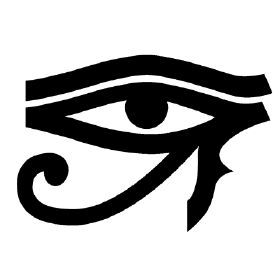

In [13]:
from IPython.display import Image

display(Image(filename="../img/developer_guides/sphinx_logo.png", embed=True))

ProbNum makes use of a number of Sphinx plugins to improve the API documentation, for example to parse this Jupyter notebook. The full list of currently used packages is listed below.

In [ ]:
# %load ../../requirements.txt
# Sphinx builds the documentation
sphinx>=3.0

# Sphinx extensions
sphinx-rtd-theme
sphinx-automodapi
sphinx-autodoc-typehints
sphinx-gallery

# Markdown conversion
m2r2

# Jupyter notebooks
nbsphinx
jupyter


## Building and Viewing the Documentation

In order to build the documentation locally and view the HTML version of the API documentation, simply run: 
```bash
tox -e docs
```
This creates a static web page under `./docs/_build/html/` which you can view in your browser by opening 
`./docs/_build/html/intro.html`.

Alternatively, if you want to build the docs in your current environment you can manually execute
```bash
cd docs
make clean
make html
```

For more information on `tox`, check out the [general development instructions](../development/contributing.rst).